# Model Audit

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project Background and Goals

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- Build a fair classifier. Is excluding the race from the feature set enough?

## Fair Re-Offend Predictor

by Steve

## Download the data

First load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


```python
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
profile
```
ProfileReport can be helpful to familiarize oneself with the dataset. It can
show us correlations within features, null values, duplicates etc.

## Data Cleaning

I got rid of difficult columns and then turned categorical features into numbers

In [4]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [5]:
df = df[['id', 'sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 
       'is_recid', 'is_violent_recid', 'decile_score.1', 'v_decile_score',
       'two_year_recid']]

### Feature Selection

##### - Features selected that could/should have been dropped:
- age: High correlation with age_cat, redundant.
- juv_other_count: Not a misdemeanor or felony, ambiguous, probably irrelevant.
- decile_score.1: same as decile_score

***Edit***
I didn't pick up on this until doing my own analysis, but "is_recid" and
"two_year_recid" possess nearly identical values. I was originally operating under the
assumption that "is_recid" meant they had already recommitted a crime prior to
this evaluation, and that the individual performing this analysis didn't
drop the feature for that reason. Without further documentation I can't confirm
this to be the case, however I believe the feature should be left out to err on
the side of caution. This would also explain the near perfect accuracy of the
model, as it would imply a data leak.
  
##### - Features dropped that could have been selected:
- r_charge_degree: could be relevant when combined with c_charge_degree

In [6]:
df.isnull().sum()

id                  0
sex                 0
age                 0
age_cat             0
race                0
juv_fel_count       0
decile_score        0
juv_misd_count      0
juv_other_count     0
priors_count        0
c_charge_degree     0
is_recid            0
is_violent_recid    0
decile_score.1      0
v_decile_score      0
two_year_recid      0
dtype: int64

In [7]:
df = df.dropna()

There didn't seem to be any missing values

In [8]:
df = df.set_index('id')

In [9]:
dummy_cols = ['sex','age_cat','race','c_charge_degree'] 

df = pd.get_dummies(df, columns=dummy_cols)

After one hot encoding, redundant columns should be dropped to avoid potential
overfitting.
For Example: the Female column becomes redundant if Male can only == 1 or 0

In [10]:
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

No cross validation, impossible to tell if the model is overfitting.

## Model Selection

I picked an SVC because I like them.

In [12]:
from sklearn.svm import SVC

# Create the SVM classifier
clf = SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Get the confusion matrix
y_pred = clf.predict(X_test)

SVC is a fine model, but can be prone to overfitting.
The data should have been scaled. A better solution might
have been to start with a simple logistic regression model with cross validation and
hyperparameter tuning, and compare those results with the SVC model (and maybe
others too) to determine which produces best. With certain models Feature
Importance could be implemented to further refine the model.

## Model Evaluation

I checked accuracy and did a Confusion Matrix

In [13]:
import numpy as np

accuracy = np.mean(y_pred == y_test)

print('Accuracy:', accuracy)

Accuracy: 0.9695121951219512


```python
from sklearn.metrics import accuracy_score
```

Would be preffered in professional settings for readability and maintainability

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[951,  54],
       [  1, 798]], dtype=int64)

A classification report would be helpful to see the precision, recall,
f1-score, and support for each class. An AUC-ROC curve would also be insightful.

## Model Summary

This is a very good and fair model because it is very accurate and predicts very well.

Terrible summary. It is vague, empty, and shows no real supporting metrics or
evidence. No actual bias checking was done. Without a classification report we
have no idea of the f1-score, precision, recall, etc. No details on what model was
used or how it was trained. No mention of validation (as none was used), so we
have no idea how the model will perform on new data. There is no context on the
problem domain or why and how certain decisions were made regarding the feature
engineering. Potential limitations of the model should also be included, as
should be recommendations or steps for improvement.

---
# Your Turn
---

## Recommendations to Improve the Model and Reduce Bias

Resampling with SMOTEENN could be helpful in reducing the bias of the model, by
increasing the size of the minority classes and removing samples from the
majority classes.

Another solution would be to simply remove the "race" feature altogether.

We could also perform a bias audit with [AI Fairness 360](https://ai-fairness-360.org/)

## Checking Bias

Using a method of your choosing retrieve feature importance for Steve's model

Compare predictions between `African-American` and `Caucasian` using a Confusion Matrix or any other tools

In [15]:
from sklearn.inspection import permutation_importance

# Use permutation_importance as the SVC instance is not linear and there is no
# easy way to check for feature importance

result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = result.importances_mean.argsort()

# Print the feature importance
for i in sorted_idx:
    print(f"Feature {i}: {result.importances_mean[i]:.4f} +/- {result.importances_std[i]:.4f}")

Feature 5: -0.0008 +/- 0.0008
Feature 2: -0.0001 +/- 0.0002
Feature 8: -0.0001 +/- 0.0002
Feature 11: 0.0000 +/- 0.0000
Feature 20: 0.0000 +/- 0.0000
Feature 19: 0.0000 +/- 0.0000
Feature 18: 0.0000 +/- 0.0000
Feature 17: 0.0000 +/- 0.0000
Feature 16: 0.0000 +/- 0.0000
Feature 15: 0.0000 +/- 0.0000
Feature 14: 0.0000 +/- 0.0000
Feature 13: 0.0000 +/- 0.0000
Feature 22: 0.0000 +/- 0.0000
Feature 21: 0.0000 +/- 0.0000
Feature 10: 0.0000 +/- 0.0000
Feature 9: 0.0000 +/- 0.0000
Feature 7: 0.0000 +/- 0.0000
Feature 4: 0.0000 +/- 0.0000
Feature 3: 0.0000 +/- 0.0000
Feature 1: 0.0000 +/- 0.0000
Feature 12: 0.0000 +/- 0.0000
Feature 0: 0.0019 +/- 0.0018
Feature 6: 0.4591 +/- 0.0125


In [16]:
from sklearn.metrics import confusion_matrix

# Subset the true labels and predictions for Caucasian samples
y_test_caucasian = y_test[X_test['race_Caucasian'] == 1]
y_pred_caucasian = y_pred[X_test['race_Caucasian'] == 1]

# Subset the true labels and predictions for African-American samples
y_test_aa = y_test[X_test['race_African-American'] == 1]
y_pred_aa = y_pred[X_test['race_African-American'] == 1]

# Compute confusion matrices
confusion_matrix_caucasian = confusion_matrix(y_test_caucasian, y_pred_caucasian)
confusion_matrix_aa = confusion_matrix(y_test_aa, y_pred_aa)

print("Confusion Matrix for Caucasian Samples:")
print(confusion_matrix_caucasian)

print("\nConfusion Matrix for African-American Samples:")
print(confusion_matrix_aa)


Confusion Matrix for Caucasian Samples:
[[376  11]
 [  1 233]]

Confusion Matrix for African-American Samples:
[[414  40]
 [  0 473]]


# Improve the Model

Implement some/all of your suggestions to make Steve's model better.

In [2]:
my_df = pd.read_csv(url)

In [3]:
my_df = my_df[['id', 'sex', 'age_cat', 'race', 'juv_fel_count',
       'juv_misd_count', 'priors_count', 'c_charge_degree', 
       'is_recid', 'is_violent_recid', 'decile_score.1',
       'two_year_recid']]

my_df.head()

,id,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_recid,is_violent_recid,decile_score.1,two_year_recid
0,1,Male,Greater than 45,Other,0,0,0,F,0,0,1,0
1,3,Male,25 - 45,African-American,0,0,0,F,1,1,3,1
2,4,Male,Less than 25,African-American,0,0,4,F,1,0,4,1
3,5,Male,Less than 25,African-American,0,1,1,F,0,0,8,0
4,6,Male,25 - 45,Other,0,0,2,F,0,0,1,0


In [4]:
my_df.race.value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [5]:
# Possible solution to overfitting, however will not use as it may lead to bias:
void_df = my_df.copy()
void_df["race"] = void_df["race"].replace({"Native American": "Other", "Asian": "Other"})
void_df.race.value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                427
Name: race, dtype: int64

In [6]:
dummy_cols = ['sex','age_cat','race','c_charge_degree'] 

my_df = pd.get_dummies(my_df, columns=dummy_cols)

In [7]:
my_df.head()

,id,juv_fel_count,juv_misd_count,priors_count,is_recid,is_violent_recid,decile_score.1,two_year_recid,sex_Female,sex_Male,...,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M
0,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,1,0
1,3,0,0,0,1,1,3,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,4,0,0,4,1,0,4,1,0,1,...,0,1,1,0,0,0,0,0,1,0
3,5,0,1,1,0,0,8,0,0,1,...,0,1,1,0,0,0,0,0,1,0
4,6,0,0,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,1,0


In [8]:
my_df.isnull().sum()

id                         0
juv_fel_count              0
juv_misd_count             0
priors_count               0
is_recid                   0
is_violent_recid           0
decile_score.1             0
two_year_recid             0
sex_Female                 0
sex_Male                   0
age_cat_25 - 45            0
age_cat_Greater than 45    0
age_cat_Less than 25       0
race_African-American      0
race_Asian                 0
race_Caucasian             0
race_Hispanic              0
race_Native American       0
race_Other                 0
c_charge_degree_F          0
c_charge_degree_M          0
dtype: int64

In [9]:
my_df = my_df.drop(columns=["sex_Female", "race_Other", "c_charge_degree_M"])

In [10]:
my_df = my_df.set_index('id')

In [11]:
my_df.head()

,juv_fel_count,juv_misd_count,priors_count,is_recid,is_violent_recid,decile_score.1,two_year_recid,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,c_charge_degree_F
id,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1
3,0,0,0,1,1,3,1,1,1,0,0,1,0,0,0,0,1
4,0,0,4,1,0,4,1,1,0,0,1,1,0,0,0,0,1
5,0,1,1,0,0,8,0,1,0,0,1,1,0,0,0,0,1
6,0,0,2,0,0,1,0,1,1,0,0,0,0,0,0,0,1


In [12]:
X = my_df.drop(columns=["two_year_recid"])
y = my_df["two_year_recid"]

In [13]:
# split data into training testing and validation

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [14]:
# this function takes a df ("X_value") and prints a count of all features.

from collections import Counter

def feature_counter(X_value):
    for feature in X_value.columns:
        print(f"{feature}: {Counter(X_value[feature])}")
    

In [15]:
Counter(y)

Counter({0: 3963, 1: 3251})

In [16]:
feature_counter(X)

juv_fel_count: Counter({0: 6932, 1: 189, 2: 51, 3: 18, 4: 12, 5: 5, 8: 2, 6: 2, 9: 1, 20: 1, 10: 1})
juv_misd_count: Counter({0: 6799, 1: 291, 2: 72, 3: 29, 4: 9, 5: 5, 6: 4, 8: 3, 12: 1, 13: 1})
priors_count: Counter({0: 2150, 1: 1397, 2: 840, 3: 568, 4: 401, 5: 334, 6: 242, 7: 210, 8: 187, 9: 149, 10: 110, 11: 98, 13: 77, 12: 73, 14: 56, 15: 51, 16: 39, 17: 36, 19: 30, 18: 26, 20: 23, 21: 22, 22: 21, 23: 16, 24: 11, 25: 9, 28: 7, 27: 7, 26: 7, 29: 5, 33: 3, 30: 2, 38: 2, 31: 2, 36: 1, 37: 1, 35: 1})
is_recid: Counter({0: 3743, 1: 3471})
is_violent_recid: Counter({0: 6395, 1: 819})
decile_score.1: Counter({1: 1440, 2: 941, 4: 769, 3: 747, 5: 681, 6: 641, 7: 592, 8: 512, 9: 508, 10: 383})
sex_Male: Counter({1: 5819, 0: 1395})
age_cat_25 - 45: Counter({1: 4109, 0: 3105})
age_cat_Greater than 45: Counter({0: 5638, 1: 1576})
age_cat_Less than 25: Counter({0: 5685, 1: 1529})
race_African-American: Counter({1: 3696, 0: 3518})
race_Asian: Counter({0: 7182, 1: 32})
race_Caucasian: Counter({0:

### This is where I noticed the collinearity between is_recid and two_year_recid

In [17]:
# Adjusting y and X values accordingly

y = X["is_recid"]
X = X.drop(columns=["is_recid", "is_violent_recid"])

In [18]:
print(Counter(y))
feature_counter(X)

Counter({0: 3743, 1: 3471})
juv_fel_count: Counter({0: 6932, 1: 189, 2: 51, 3: 18, 4: 12, 5: 5, 8: 2, 6: 2, 9: 1, 20: 1, 10: 1})
juv_misd_count: Counter({0: 6799, 1: 291, 2: 72, 3: 29, 4: 9, 5: 5, 6: 4, 8: 3, 12: 1, 13: 1})
priors_count: Counter({0: 2150, 1: 1397, 2: 840, 3: 568, 4: 401, 5: 334, 6: 242, 7: 210, 8: 187, 9: 149, 10: 110, 11: 98, 13: 77, 12: 73, 14: 56, 15: 51, 16: 39, 17: 36, 19: 30, 18: 26, 20: 23, 21: 22, 22: 21, 23: 16, 24: 11, 25: 9, 28: 7, 27: 7, 26: 7, 29: 5, 33: 3, 30: 2, 38: 2, 31: 2, 36: 1, 37: 1, 35: 1})
decile_score.1: Counter({1: 1440, 2: 941, 4: 769, 3: 747, 5: 681, 6: 641, 7: 592, 8: 512, 9: 508, 10: 383})
sex_Male: Counter({1: 5819, 0: 1395})
age_cat_25 - 45: Counter({1: 4109, 0: 3105})
age_cat_Greater than 45: Counter({0: 5638, 1: 1576})
age_cat_Less than 25: Counter({0: 5685, 1: 1529})
race_African-American: Counter({1: 3696, 0: 3518})
race_Asian: Counter({0: 7182, 1: 32})
race_Caucasian: Counter({0: 4760, 1: 2454})
race_Hispanic: Counter({0: 6577, 1: 63

In [19]:
# re-split the data
X = X.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# resample data with SMOTEENN

from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state=42)

X_sme, y_sme = sme.fit_resample(X_train, y_train)

feature_counter(X_sme)

juv_fel_count: Counter({0: 1789, 1: 59, 2: 14, 3: 8, 4: 4, 5: 2, 9: 1, 10: 1, 20: 1})
juv_misd_count: Counter({0: 1727, 1: 95, 2: 34, 3: 15, 5: 3, 4: 3, 8: 1, 12: 1})
priors_count: Counter({0: 621, 1: 280, 2: 195, 3: 166, 4: 82, 7: 70, 8: 65, 6: 52, 5: 51, 11: 36, 10: 36, 9: 36, 13: 35, 12: 18, 17: 16, 16: 15, 19: 15, 14: 15, 18: 13, 23: 9, 22: 9, 15: 8, 21: 7, 25: 5, 28: 5, 20: 4, 24: 3, 26: 3, 29: 2, 30: 2, 27: 2, 36: 1, 37: 1, 31: 1})
decile_score.1: Counter({1: 482, 2: 222, 8: 181, 10: 170, 9: 152, 5: 142, 6: 140, 3: 139, 7: 136, 4: 115})
sex_Male: Counter({1: 1512, 0: 367})
age_cat_25 - 45: Counter({1: 1071, 0: 808})
age_cat_Greater than 45: Counter({0: 1443, 1: 436})
age_cat_Less than 25: Counter({0: 1509, 1: 370})
race_African-American: Counter({1: 950, 0: 929})
race_Asian: Counter({0: 1865, 1: 14})
race_Caucasian: Counter({0: 1256, 1: 623})
race_Hispanic: Counter({0: 1714, 1: 165})
race_Native American: Counter({0: 1871, 1: 8})
c_charge_degree_F: Counter({1: 1286, 0: 593})


In [24]:
# scaling the data 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_sme_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Simple Logistic Regression with GridSearch

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga', 'lbfgs'], 
    'max_iter': [1, 5, 10, 50, 100, 500, 1000],
    'class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(LogisticRegression(random_state=10), param_grid, cv=10, verbose=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_sme_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 10 folds for each of 336 candidates, totalling 3360 fits
Best parameters found:  {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.68


c:\ProgramData\anaconda3\envs\cainhurst\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
840 fits failed out of a total of 3360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
840 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\cainhurst\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\envs\cainhurst\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\ProgramData\anaconda3\envs\cainhurst\lib\site-packages\sklearn\linear_model\_log

In [25]:
from sklearn.metrics import balanced_accuracy_score

# Define the best_model
best_model = grid_search.best_estimator_

# Now, you can use best_model to make predictions
y_pred = best_model.predict(X_test_scaled)
test_score = balanced_accuracy_score(y_test, y_pred)
print(f"Test Balanced Accuracy Score: {test_score}")

Test Balanced Accuracy Score: 0.6649864536458878


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(y_test, y_pred)

array([[533, 256],
       [226, 428]], dtype=int64)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       789
           1       0.63      0.65      0.64       654

    accuracy                           0.67      1443
   macro avg       0.66      0.66      0.66      1443
weighted avg       0.67      0.67      0.67      1443



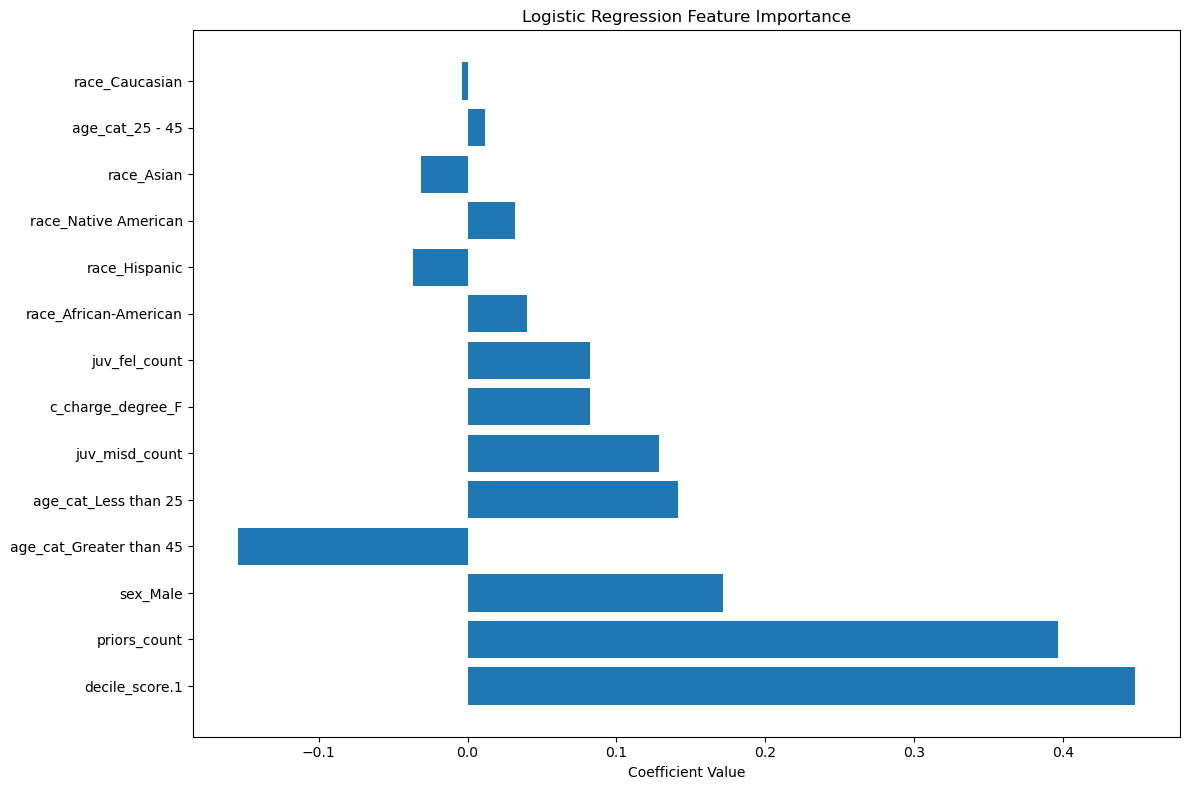

In [28]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Assuming 'model' is your trained logistic regression model and 'feature_names' is a list of feature names
coefficients = best_model.coef_[0]
feature_names = X_train.columns  # or the list of your feature names

# Plotting
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
plt.barh(np.array(feature_names)[sorted_idx], coefficients[sorted_idx])
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importance")
plt.tight_layout()


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_dist = {'n_estimators': [10, 20, 40, 80, 100, 200],
              'max_depth': [2, 4, 8, 16, 32],
              "max_features": ['sqrt', 'log2', None],
              "class_weight": ['balanced', 'balanced_subsample', None]
              }

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist,
                                 n_jobs=-1, 
                                 verbose=3,
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_sme_scaled, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best hyperparameters: {'n_estimators': 10, 'max_features': 'log2', 'max_depth': 8, 'class_weight': 'balanced_subsample'}


In [30]:
# Predict on the validation set
y_pred = best_rf.predict(X_test_scaled)

# Calculate the balanced accuracy score
score = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy Score: {score}")

Balanced Accuracy Score: 0.6734456576086325


In [31]:
confusion_matrix(y_test, y_pred)

array([[556, 233],
       [234, 420]], dtype=int64)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       789
           1       0.64      0.64      0.64       654

    accuracy                           0.68      1443
   macro avg       0.67      0.67      0.67      1443
weighted avg       0.68      0.68      0.68      1443



In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_sme_scaled.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
model.fit(X_sme_scaled, y_train, epochs=10, batch_size=16, validation_split=0.25)
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/10
271/271 [==============================] - 5s 4ms/step - loss: 0.6808 - accuracy: 0.5538 - val_loss: 0.6552 - val_accuracy: 0.6577
Epoch 2/10
271/271 [==============================] - 1s 3ms/step - loss: 0.6622 - accuracy: 0.6377 - val_loss: 0.6408 - val_accuracy: 0.6681
Epoch 3/10
271/271 [==============================] - 1s 3ms/step - loss: 0.6481 - accuracy: 0.6534 - val_loss: 0.6328 - val_accuracy: 0.6729
Epoch 4/10
271/271 [==============================] - 1s 3ms/step - loss: 0.6455 - accuracy: 0.6520 - val_loss: 0.6290 - val_accuracy: 0.6722
Epoch 5/10
271/271 [==============================] - 1s 3ms/step - loss: 0.6425 - accuracy: 0.6527 - val_loss: 0.6289 - val_accuracy: 0.6701
Epoch 6/10
271/271 [==============================] - 1s 3ms/step - loss: 0.6337 - accuracy: 0.6650 - val_loss: 0.6274 - val_accuracy: 0.6660
Epoch 7/10
271/271 [==============================] - 1s 3ms/step - loss: 0.6394 - accuracy: 0.6592 - val_loss: 0.6214 - val_accuracy: 0.6681
Epoch 

In [34]:
import xgboost as xgb

param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 10],
    'max_depth': [3, 5, 7, 10, 20],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [50, 100, 200, 300]
}

clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 10],
                         'max_depth': [3, 5, 7, 10, 20],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='accuracy', verbose=10)

In [35]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.7}
Best cross-validation score: 0.68
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       789
           1       0.64      0.66      0.65       654

    accuracy                           0.68      1443
   macro avg       0.68      0.68      0.68      1443
weighted avg       0.68      0.68      0.68      1443



In [36]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'degree': [2, 3, 4, 5],  # Only used by 'poly' kernel
    'coef0': [-1, 0, 1],    # Used by 'poly' and 'sigmoid' kernels
}

# Using RandomizedSearchCV with increased iterations
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, 
                                   n_iter=100, verbose=2, cv=5, n_jobs=1, 
                                   random_state=42)

# Using a larger subset of the data for hyperparameter tuning
subset_indices = np.random.choice(len(X_train_scaled), 5000, replace=False)
X_subset = X_train_scaled[subset_indices]
y_subset = y_train.iloc[subset_indices]

random_search.fit(X_subset, y_subset)

print("Best parameters found: ", random_search.best_params_)

# Evaluate on test data
accuracy = random_search.best_estimator_.score(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END .C=0.01, coef0=0, degree=5, gamma=0.001, kernel=rbf; total time=   9.9s
[CV] END .C=0.01, coef0=0, degree=5, gamma=0.001, kernel=rbf; total time=   3.9s
[CV] END .C=0.01, coef0=0, degree=5, gamma=0.001, kernel=rbf; total time=   3.4s
[CV] END .C=0.01, coef0=0, degree=5, gamma=0.001, kernel=rbf; total time=   3.5s
[CV] END .C=0.01, coef0=0, degree=5, gamma=0.001, kernel=rbf; total time=   3.8s
[CV] END .C=1, coef0=-1, degree=3, gamma=0.01, kernel=linear; total time=   2.4s
[CV] END .C=1, coef0=-1, degree=3, gamma=0.01, kernel=linear; total time=   2.5s
[CV] END .C=1, coef0=-1, degree=3, gamma=0.01, kernel=linear; total time=   4.3s
[CV] END .C=1, coef0=-1, degree=3, gamma=0.01, kernel=linear; total time=   2.5s
[CV] END .C=1, coef0=-1, degree=3, gamma=0.01, kernel=linear; total time=   2.7s
[CV] END ...C=0.1, coef0=1, degree=4, gamma=auto, kernel=rbf; total time=   3.0s
[CV] END ...C=0.1, coef0=1, degree=4, gamma=auto, kernel=rbf; total time=   3.8s
[CV] END ...C=0.1, coef0=1, 

In [25]:
from sklearn.svm import SVC
svc_model = SVC(kernel='rbf', gamma=0.001, degree=5, coef0=1, C=100)

svc_model.fit(X_sme_scaled, y_train)

SVC(C=100, coef0=1, degree=5, gamma=0.001)

In [26]:
pred = svc_model.predict(X_test_scaled)

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(pred, y_test)

array([[561, 234],
       [228, 420]], dtype=int64)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       795
           1       0.64      0.65      0.65       648

    accuracy                           0.68      1443
   macro avg       0.68      0.68      0.68      1443
weighted avg       0.68      0.68      0.68      1443



In [33]:
from sklearn.svm import SVC

svc_model.fit(X_train, y_train)
pred = svc_model.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       811
           1       0.63      0.66      0.64       632

    accuracy                           0.68      1443
   macro avg       0.68      0.68      0.68      1443
weighted avg       0.68      0.68      0.68      1443



In [35]:
# Subset the true labels and predictions for Caucasian samples
y_test_caucasian = y_test[X_test['race_Caucasian'] == 1]
y_pred_caucasian = pred[X_test['race_Caucasian'] == 1]

# Subset the true labels and predictions for African-American samples
y_test_aa = y_test[X_test['race_African-American'] == 1]
y_pred_aa = pred[X_test['race_African-American'] == 1]

# Compute confusion matrices
confusion_matrix_caucasian = confusion_matrix(y_test_caucasian, y_pred_caucasian)
confusion_matrix_aa = confusion_matrix(y_test_aa, y_pred_aa)

print("Confusion Matrix for Caucasian Samples:")
print(confusion_matrix_caucasian)

print("\nConfusion Matrix for African-American Samples:")
print(confusion_matrix_aa)


Confusion Matrix for Caucasian Samples:
[[253  57]
 [ 92 103]]

Confusion Matrix for African-American Samples:
[[207 134]
 [106 284]]


In [85]:
fair_df = pd.read_csv(url)

fair_df = fair_df[['id', 'sex', 'age_cat', 'race', 'juv_fel_count',
       'juv_misd_count', 'priors_count', 'c_charge_degree', 
       'is_recid', 'decile_score.1']]
dummy_cols = ['sex','age_cat','c_charge_degree'] 

fair_df = pd.get_dummies(fair_df, columns=dummy_cols)

fair_df = fair_df.drop(columns=["sex_Female", "c_charge_degree_M"])
X = fair_df.drop(columns=["is_recid", "race"])
fair_dff = fair_df.set_index('id')
y = fair_df["is_recid"]
race = df["race"]


In [104]:
clf = LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000, penalty='l2', solver='saga')
clf.fit(X, y)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000,
                   solver='saga')

In [105]:
from fairlearn.reductions import ExponentiatedGradient, TruePositiveRateParity

# Create the fairness constraint. In this case, it's true positive rate parity.
constraint = TruePositiveRateParity()

# Train the ExponentiatedGradient model.
clf_mitigated = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=10000),
    constraints=constraint
)
clf_mitigated.fit(X, y, sensitive_features=race)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x000002A482BDD280>,
                      estimator=LogisticRegression(max_iter=10000),
                      nu=0.002753280121250147)

In [109]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict with the original and mitigated models
y_pred = clf.predict(X)
y_pred_mitigated = clf_mitigated.predict(X)

# Define the metrics
metrics_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score,
    # Uncomment the next line if you have probability predictions for roc_auc
    # 'roc_auc': roc_auc_score  
}

# Assess performance
# Evaluate the initial model
metric_frame_initial = MetricFrame(
    metrics=metrics_dict,
    y_true=y,
    y_pred=y_pred,
    sensitive_features=race
)

# Evaluate the mitigated model
metric_frame_mitigated = MetricFrame(
    metrics=metrics_dict,
    y_true=y,
    y_pred=y_pred_mitigated,
    sensitive_features=race
)

print("Initial Model Results:")
print(metric_frame_initial.by_group)
print("\nMitigated Model Results:")
print(metric_frame_mitigated.by_group)


Initial Model Results:
                  accuracy  precision    recall  f1_score
race                                                     
African-American  0.628517   0.637609  0.754420  0.691114
Asian             0.812500   0.692308  0.818182  0.750000
Caucasian         0.626732   0.546462  0.625366  0.583258
Hispanic          0.612245   0.496503  0.579592  0.534840
Native American   0.666667   0.692308  0.818182  0.750000
Other             0.628647   0.509434  0.566434  0.536424

Mitigated Model Results:
                  accuracy  precision    recall  f1_score
race                                                     
African-American  0.457792   0.603896  0.045678  0.084932
Asian             0.656250   0.000000  0.000000  0.000000
Caucasian         0.583537   0.521739  0.035122  0.065814
Hispanic          0.612245   0.454545  0.040816  0.074906
Native American   0.444444   1.000000  0.090909  0.166667
Other             0.628647   0.714286  0.034965  0.066667


c:\ProgramData\anaconda3\envs\cainhurst\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
